# PROSAIL soil spectra

In [1]:
import pkgutil
from collections import namedtuple
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
# Plot default soil spectra that are in the prosail package

soil_spectraf = "../../data/soil_reflectance_prosail.txt"
rsoil1, rsoil2 = np.loadtxt(soil_spectraf, unpack=True)
wavelen = np.arange(400,2501)

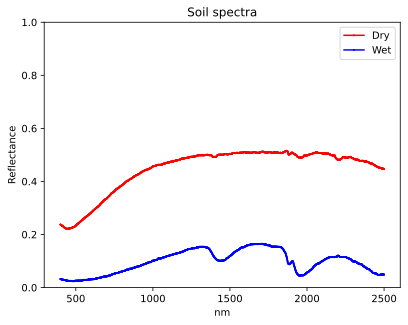

In [3]:
plt.plot(wavelen, rsoil1, label='Dry', marker='o', linestyle='-', color='r', markersize=1)
plt.plot(wavelen, rsoil2, label='Wet', marker='o', linestyle='-', color='b', markersize=1)
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title('Soil spectra')
plt.ylim((0,1))
plt.legend()

plt.show()

# PROSAIL soil spectra that is passed to RTM
$ soil\_spectra = rsoil * (psoil * soil\_spectrum1 + (1.0 - psoil) * soil\_spectrum2) $
- $soil\_spectrum1$: dry
- $soil\_spectrum2$: wet
- Lukas: $rsoil$ and $psoil$ unifrom between 0 and 1

In [17]:
# Create 50k runs with psoil and rsoil unif distr 0-1

# Parameters
num_samples = 50000
rsoil = np.random.uniform(0, 1, size=num_samples)
psoil = np.random.uniform(0, 1, size=num_samples)

# Calculate soil_spectra for 50k runs
rsoil = rsoil[:, np.newaxis]
soil_spectra = rsoil * (psoil[:, np.newaxis] * rsoil1 + (1.0 - psoil[:, np.newaxis]) * rsoil2)

# soil_spectra now contains 50000 spectra, each with 2101 bands (corresponding to wavelengths 400-2500)
# Dimensions of soil_spectra: (num_samples, len(wavelen))

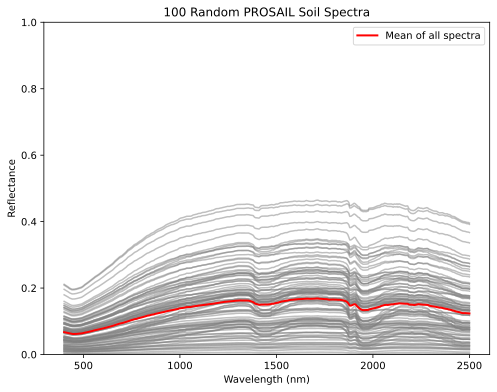

In [34]:
n = 100
random_indices = np.random.randint(num_samples, size=n)
mean_spectrum = np.mean(soil_spectra, axis=0)

# Plotting
plt.figure(figsize=(8, 6))
for idx in random_indices:
    plt.plot(wavelen, soil_spectra[idx], alpha=0.5, color='grey', label='_nolegend_')  # Use label='_nolegend_' to suppress legend entry

# Plot mean spectrum
mean_spectrum = np.mean(soil_spectra, axis=0)
plt.plot(wavelen, mean_spectrum, color='r', label='Mean of all spectra', linewidth=2)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title(f'{n} Random PROSAIL Soil Spectra')
plt.legend()
plt.ylim((0, 1))
plt.show()

# Sampled spectra that is passed to RTM

In [4]:
spectra = pd.read_pickle('../../results/GEE_baresoil_v2/sampled_spectra_all_CH.pkl')

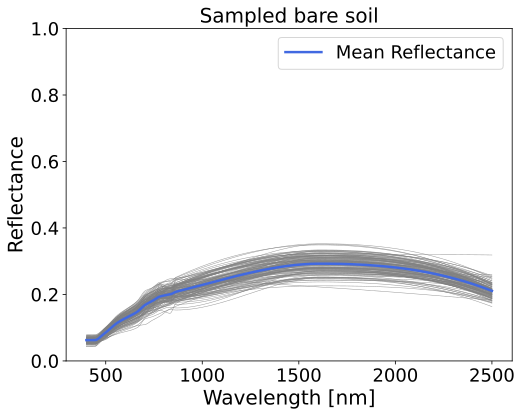

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

spectra.T.plot(ax=ax, legend=False, color='grey', linewidth=0.5, alpha=0.8)

# Plot the mean line in bold
mean_spectra = spectra.mean(axis=0)
mean_spectra_df = mean_spectra.reset_index().rename(columns={0: 'Reflectance'})
mean_spectra_df.columns = ['nm', 'Reflectance']
mean_spectra_df.plot(ax=ax, x='nm', y='Reflectance', color='royalblue', linewidth=2.5, label='Mean Reflectance')

plt.ylim((0,1))
plt.ylabel('Reflectance', fontsize=20)
plt.xlabel('Wavelength [nm]', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[-1]], labels=[labels[-1]], loc='upper right', fontsize=18)
plt.title('Sampled bare soil',fontsize=20)
plt.show()

In [6]:
# Apply scaling

# Parameters
num_generations = 400
num_spectra = len(spectra)
num_bands = 2101  # Assuming the number of bands is from 400 to 2500

rsoil = np.random.uniform(0, 1.5, size=(num_generations*num_spectra))
rsoil = rsoil[:, np.newaxis]

# Initialize an array to store the generated soil spectra
soil_spectra = np.zeros((num_generations*num_spectra, num_bands))

# Compute soil_spectra for each generation and each original spectrum
for s in range(num_spectra):
    for i in range(num_spectra):
        soil_spectra[s * num_generations + i, :] = rsoil[s * num_generations + i, :] * spectra.iloc[s].values

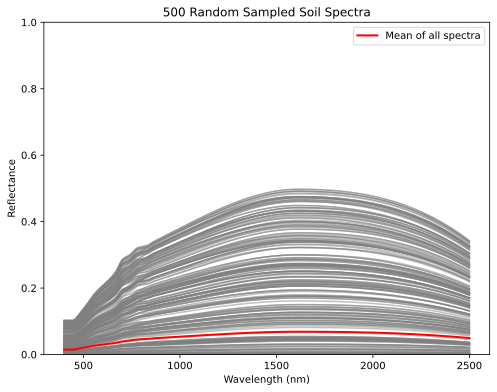

In [8]:
n = 500
random_indices = np.random.randint(n, size=n)
mean_spectrum = np.mean(soil_spectra, axis=0)
wavelen = np.arange(400, 2501)

# Plotting
plt.figure(figsize=(8, 6))
for idx in random_indices:
    plt.plot(wavelen, soil_spectra[idx], alpha=0.5, color='grey', label='_nolegend_')  # Use label='_nolegend_' to suppress legend entry

# Plot mean spectrum
mean_spectrum = np.mean(soil_spectra, axis=0)
plt.plot(wavelen, mean_spectrum, color='r', label='Mean of all spectra', linewidth=2)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title(f'{n} Random Sampled Soil Spectra')
plt.legend()
plt.ylim((0, 1))
plt.show()

# Simulate prosail with LAI = 0 and see what spectra looks like 
- is it simular to the bare soil spectra?
- PROSAIL can't take LAI=0 (range needs to be positive), so did a uniform distribution between 0 and 0.000001

In [3]:
lut_path = '../../results/lut_based_inversion/prosail_null_lai_lai-cab-ccc-car_lut_no-constraints.pkl'

In [4]:
df = pd.read_pickle(lut_path)

In [11]:
# CHeck if any bare soil/LAI=0

print('Number of simulations with LAI=0:', len(df[df.lai==0]))
print('Smallest LAI value used for simulation:', df.lai.min())

Number of simulations with LAI=0: 0
Smallest LAI value used for simulation: 7.2449638492178e-11


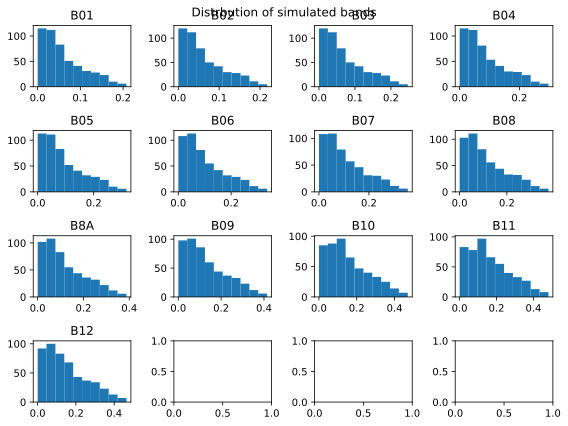

In [50]:
# Look at distrbution generated bands

columns_to_plot = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
 'B8A', 'B09', 'B10', 'B11', 'B12']

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    df[col].hist(ax=axes[i], bins=10, grid=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.suptitle("Distrbution of simulated bands")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


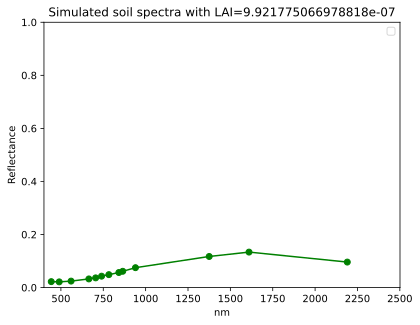

In [48]:
# Plot some spectra to compare to the soil spectra

s2_wavelen = [443, 490, 560, 665, 705, 740, 783, 842, 865, 940, 1375, 1610, 2190]
df_bands = df[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']]
i = 10

plt.plot(s2_wavelen, df_bands.iloc[i], marker='o', linestyle='-', color='g')
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title(f'Simulated soil spectra with LAI={df["lai"].iloc[i]}')
plt.ylim((0,1))
plt.xlim((400,2501))
plt.legend()

plt.show()

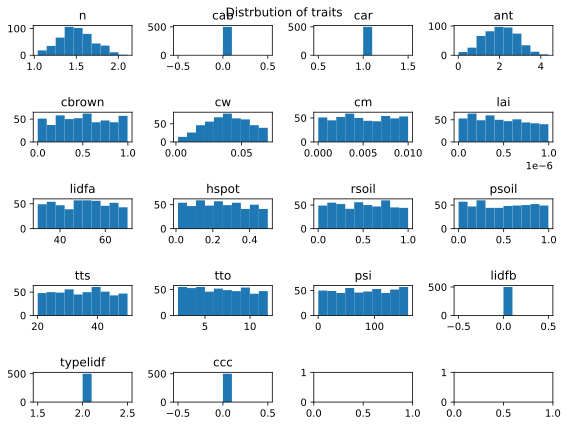

In [49]:
# Look at distrbution sampled variables when LAI=0

columns_to_plot = ['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lai', 'lidfa',
 'hspot', 'rsoil', 'psoil', 'tts', 'tto', 'psi', 'lidfb', 'typelidf', 'ccc']

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    df[col].hist(ax=axes[i], bins=10, grid=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.suptitle("Distrbution of traits")
plt.show()